In [1]:
import gym
import numpy as np
import time, os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import pandas as pd
import utils_discrete
from IPython.display import clear_output
import chain_custom
import sys

In [2]:
# plotting parameters
plotNorm = False          # plot norm graphs
save = True              # save graphs for upper bounds
compEmp = True           # compute all expectations empirically

path = "./tmp/"           # path for images savings
bounds = {"policy": {}}   # dict for saving bounds

### Frozen Lake

In [3]:
flag = True
env = gym.make('FrozenLake-v0', is_slippery=flag)
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [ ]:
N_states = env.observation_space.n
N_actions = env.action_space.n
N_br = 3
gamma = 0.9

# p(s'|s, a)
p_next_state = utils_discrete.get_dynamics(env)
p_ksi = [1./3, 1./3, 1./3]

r_sa= np.zeros((N_states, N_states, N_actions))
r_sa[15, 14, :] = 10
r_sa = np.sum(r_sa*p_next_state, axis=0)

In [ ]:
# Y_k^(x, a)
Y_states = np.zeros((N_states, N_actions, 3), dtype=int)

for i in range(env.observation_space.n):
    for k in range(env.action_space.n):
        ksi = 0
        for j in range(env.observation_space.n):
            if p_next_state[j, i, k] == 1/3:
                Y_states[i, k, ksi] = j
                ksi += 1
            if p_next_state[j, i, k] == 1/3*2:
                Y_states[i, k, ksi] = j
                ksi += 1
                
                Y_states[i, k, ksi] = j
                ksi += 1
                
            if p_next_state[j, i, k] == 1:
                Y_states[i, k, :] = j

In [ ]:
# Value Iteration
T = 1000     #M1=M2=T
policy_determ = utils_discrete.perform_value_iteration(p_next_state, r_sa, Y_states, p_ksi, T, gamma, bounds, .00001, 0.1, 
                            plotNorm, compEmp, path, save)

Norm upper: 0.04512672005924051


episode: 39900, length: 47



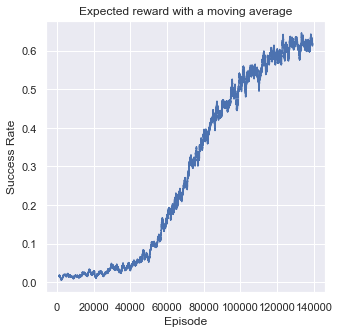

In [ ]:
# Reinforce tabular policy approximation
# init policy
theta = np.ones(env.observation_space.n*env.action_space.n)
policy = utils_discrete.make_policy(env, theta)

lr = 0.01
n = 40000
score = []

T = 10000     #M1=M2=T

for episode in tqdm(range(n)):
    reward = 0
    while reward == 0:
        state = env.reset()
        trajectory = []
        rewards = []
        steps = 0
        while True:
            probs = policy[state]
            action = np.random.choice(np.arange(env.action_space.n), p=probs)
            new_state, reward, done, _ = env.step(action)
            trajectory.append([state, action])
            rewards.append(reward)
            steps += 1
            if done:
                break
            state = new_state
        score.append(reward)
    if done:
        theta, policy = utils_discrete.update_policy_tabular(env, policy, theta, rewards, trajectory, lr, gamma)
        if episode % 100 == 0:
            clear_output(True)
            sys.stdout.write("episode: {}, length: {}\n".format(episode, steps))
    
    if episode in [0, 10000, 30000]: #% period_savings == 0:
        V_star, upper, _ = utils_discrete.getDiscrStationaryBounds(policy, r_sa, 
                                                                p_next_state, p_ksi, Y_states, gamma, int(T), 
                                                                0.01, plotNorm, compEmp)
    
        bounds["policy"]["V"] = V_star
        bounds["policy"]["upper"] = upper
        utils_discrete.plotBounds(bounds, iter_num=episode, path=path, save=True)
        T /= 1.5
    
moving_avg_reward = []
window = 1000
for i in range(window, len(score)):
    moving_avg_reward.append(sum(score[i-window:i])/window)

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(range(window, len(score)), moving_avg_reward)
ax.set(xlabel='Episode', ylabel='Success Rate', title='Expected reward with a moving average')
plt.show()

### Chain

In [ ]:
p = 0.5              # noise in chain
gamma = .8           # discounting factor
env = chain_custom.Chain(p, 15)
env.render()


T<-S<=>S<=>S<=>S<=>S<=>S<=>S<=>S<=>S<=>S<=>S<=>S<=>S->T


In [ ]:
#0 - left, 1 - right

p_ksi = [p/2, 1-p/2]
# p(s'|s, a)
p_next_state = utils_discrete.get_dynamics(env)

# r(s, a)
r_sas = env.get_rewards()
r_sa = np.einsum('kmn,nkm->km', r_sas, p_next_state)

N_states = env.observation_space.n
N_actions = env.action_space.n
states = np.arange(N_states)
actions = np.arange(N_actions)

N_br = 2
P = p_next_state
ksi = np.random.choice(a=np.arange(N_br), size=1, p=p_ksi)[0]

opt_policy = np.array((env.left_states + 1)*[[1., 0.]] +\
           (env.right_states + 2)*[[0., 1.]])
random_policy = 0.5*np.ones((env.observation_space.n, env.action_space.n))

In [ ]:
# Y_k^(x, a)
Y_states = np.zeros((N_states, N_actions, N_br), dtype=int) - 1

for i in range(N_states):
    for k in range(N_actions):
        for j in range(N_states):
            if P[j, i, k] == p_ksi[0]:
                Y_states[i, k, 0] = j
            if P[j, i, k] == p_ksi[1]:
                Y_states[i, k, 1] = j
            if P[j, i, k] == 1:
                Y_states[i, k, 0] = j
                Y_states[i, k, 1] = j

In [ ]:
# Value Iteration
T = 1000     #M1=M2=T
policy_determ = utils_discrete.perform_value_iteration(P, r_sa, Y_states, p_ksi, T, gamma, bounds, .00001, 0.1, 
                            plotNorm, compEmp, path, save)

Norm upper: 0.037908481610695315


### Garnet

In [ ]:
#parameters of the system

N_states = 20 # number of states
N_actions = 5 # number of actions
N_br = 2      # number of available transitions (branching parameter)
gamma = 0.9   # discount factor
seed = 42     # random state 
states = np.arange(N_states)
actions = np.arange(N_actions)
p_ksi = np.ones(N_br)/N_br

reward_matrix = utils_discrete.get_reward(N_states, N_actions, random_state=seed) # reward function
P = utils_discrete.transition_matrix(N_states, N_actions, N_br, random_state=seed) #transition matrix

In [ ]:
# Y_k^(x, a)
Y_states = np.zeros((N_states, N_actions, N_br), dtype=int)-1

for i in range(N_states):
    for k in range(N_actions):
        ksi = 0
        for j in range(N_states):
            if P[j, i, k] == 1/N_br:
                Y_states[i, k, ksi] = j
                ksi += 1

In [ ]:
# Value Iteration
T = 3000     #M1=M2=T
policy_determ = utils_discrete.perform_value_iteration(P, reward_matrix, Y_states, p_ksi, T, gamma, 
                                                       bounds, .01, 0.4, plotNorm, compEmp, path, save)

Norm upper: 0.1594279136902338
